In [19]:
from karateclub import Node2Vec

from kuramoto import Kuramoto
from kuramoto.db_metrics import *
import networkx as nx

In [20]:
def gen_KM_nodynamics(nodes, num_samples, edge_var="L", random_K=False, half_sync=False):
    
    graph_list = []
    df = pd.DataFrame(columns=['# Edges', '# Nodes', 'Min Degree', 'Max Degree', 'Diameter', 'Concentrated'])
    
    for i in range(num_samples):
        nodes = nodes
        
        assert(edge_var in ["L", "H", "F"]), "The edge variance can either be \"L\" (Low), \"H\" (High), or \"F\" (Fixed)."
        
        if edge_var=="L":
            neighbors = int(random.uniform(15, 20))
            
        elif edge_var=="H":
            neighbors = int(random.uniform(1, 20))
            
        else:
            neighbors = 15
        
        probability = random.uniform(0, 1)
        G = nx.newman_watts_strogatz_graph(nodes, neighbors, probability)
        graph_list.append(G)
        
        if random_K: K = random.uniform(0.5, 4.5)
        else: K = 1.96
        
        if nx.is_connected(G):
            edges = G.number_of_edges()
            nodes = G.number_of_nodes()
            degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
            dmax = max(degree_sequence)
            dmin = min(degree_sequence)
            diam = nx.diameter(G)

            adj_mat = nx.to_numpy_array(G)

            if half_sync:
                natfreqs = np.repeat(2 * np.pi * 0, nodes)
                model = Kuramoto(coupling=K, dt=0.01, T=25, natfreqs=natfreqs, half_sync=half_sync)
            else:
                model = Kuramoto(coupling=K, dt=0.01, T=25, n_nodes=nodes, half_sync=half_sync)

            sim = model.run(adj_mat)
            conc = int(model.concentrated)
            
            df.at[len(df.index)] = [edges, nodes, dmin, dmax, diam, conc]
            
        else:
            graph_list.remove(G)
      
    
    return df, graph_list
    



In [21]:
def n2v_embedding(df):

    df_n2v = pd.DataFrame()

    for graph in graph_list:        
        n2v = Node2Vec(dimensions = 1)
        n2v.fit(graph)
        embed = n2v.get_embedding()
        df_embed = pd.DataFrame(embed.T)
        df_n2v = pd.concat([df_n2v, df_embed], ignore_index=True, axis=0)
        
    return df_n2v


### Kurumoto with LOW edge variance (100 samples)

In [40]:
df, graph_list = gen_KM_nodynamics(20, 100, edge_var="L", half_sync = False)

df_n2v = n2v_embedding(df)

df_final = pd.concat([df_n2v, df], axis=1)

In [41]:
df_final

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,# Edges,# Nodes,Min Degree,Max Degree,Diameter,Concentrated
0,1.379904,1.501820,1.408924,1.347474,1.476525,1.324368,1.378802,1.256782,1.465850,1.212807,...,1.546181,1.492282,1.445183,1.175888,183,20,18,19,2,0
1,1.384095,1.456624,1.311246,1.406641,1.461192,1.505263,1.494000,1.327683,1.467066,1.181150,...,1.349471,1.480798,1.553428,1.502450,190,20,19,19,1,0
2,1.334465,1.678701,1.496002,1.348622,1.383939,1.569691,1.407757,1.420725,1.440247,1.413029,...,1.408192,1.425718,1.327266,1.365138,190,20,19,19,1,0
3,1.332249,1.663775,1.493196,1.343472,1.362131,1.559869,1.410844,1.431064,1.419546,1.385742,...,1.402535,1.439414,1.347171,1.343737,190,20,19,19,1,0
4,1.308470,1.677012,1.493469,1.356279,1.385556,1.531262,1.388208,1.421192,1.447412,1.396566,...,1.386968,1.434978,1.338598,1.357907,190,20,19,19,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.386106,1.165371,1.450790,1.282959,1.456911,1.458063,1.467186,1.575476,1.485210,1.278607,...,1.351443,1.407749,1.475060,1.521874,190,20,19,19,1,0
96,1.339575,1.701056,1.500561,1.354302,1.394614,1.572000,1.405187,1.390758,1.434848,1.395596,...,1.403557,1.445904,1.314859,1.356963,190,20,19,19,1,0
97,1.302082,1.563479,1.349847,1.345691,1.418819,1.354389,1.312443,1.386003,1.421737,1.320422,...,1.480863,1.452183,1.478386,1.328328,190,20,19,19,1,0
98,1.410384,1.286607,1.429764,1.484662,1.405016,1.511539,1.486347,1.368564,1.372490,1.393898,...,1.389075,1.446820,1.280679,1.322552,190,20,19,19,1,0


In [42]:
X, y = df_final.iloc[:, 0:20], df_final.iloc[:, [-1]]
y = y.astype('int')
sampler = RandomOverSampler()
X_resampled, y_resampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

In [43]:
df_final['Concentrated'].value_counts()

0    87
1    13
Name: Concentrated, dtype: int64

In [44]:
y_train.value_counts()

Concentrated
0               65
1               65
dtype: int64

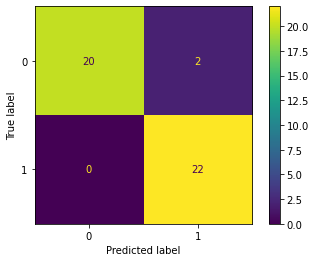

Precision: 0.917
Recall: 1.000
F1: 0.957
Accuracy: 0.955


In [45]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### Kurumoto with LOW edge variance (200 samples)

In [28]:
df, graph_list = gen_KM_nodynamics(20, 200, edge_var="L", half_sync = False)

df_n2v = n2v_embedding(df)

df_final = pd.concat([df_n2v, df], axis=1)

In [29]:
X, y = df_final.iloc[:, 0:20], df_final.iloc[:, [-1]]
y = y.astype('int')
sampler = RandomOverSampler()
X_resampled, y_resampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

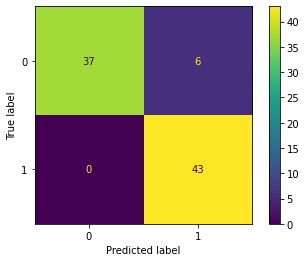

Precision: 0.878
Recall: 1.000
F1: 0.935
Accuracy: 0.930


In [30]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### Kurumoto with HIGH edge variance (100 samples)

In [46]:
df, graph_list = gen_KM_nodynamics(20, 100, edge_var="H", half_sync = False)

df_n2v = n2v_embedding(df)

df_final = pd.concat([df_n2v, df], axis=1)

In [47]:
X, y = df_final.iloc[:, 0:20], df_final.iloc[:, [-1]]
y = y.astype('int')
sampler = RandomOverSampler()
X_resampled, y_resampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

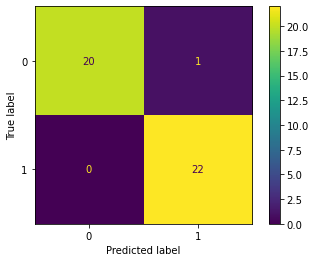

Precision: 0.957
Recall: 1.000
F1: 0.978
Accuracy: 0.977


In [48]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### Kurumoto with HIGH edge variance (200 samples)

In [37]:
df, graph_list = gen_KM_nodynamics(20, 200, edge_var="H", half_sync = False)

df_n2v = n2v_embedding(df)

df_final = pd.concat([df_n2v, df], axis=1)

In [38]:
X, y = df_final.iloc[:, 0:20], df_final.iloc[:, [-1]]
y = y.astype('int')
sampler = RandomOverSampler()
X_resampled, y_resampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

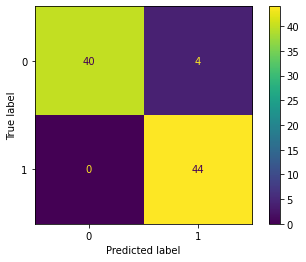

Precision: 0.917
Recall: 1.000
F1: 0.957
Accuracy: 0.955


In [39]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [50]:
df_final['Concentrated'].value_counts()


0    86
1    11
Name: Concentrated, dtype: int64

In [51]:
y_train.value_counts()

Concentrated
0               65
1               64
dtype: int64